This project demonstrates a beginner-friendly approach to MNIST classification using an XGBoost classifier. The MNIST dataset consists of images in formats such as JPG, JPEG, and PNG, which I process using OpenCV to convert them into numerical data suitable for machine learning. At the end, I test the classifier using custom inputs that I drew in Paint, and the model performs well enough to meet my expectations, though I’m giving it some slack for a bit of room to improve.

## Imports and installs

In [1]:
# !pip install xgboost

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

folder_path = '../MNIST/mnist-png' # 'C:/Users/gurau/Desktop/Jupyter_Lab/3. Computer Vision/MNIST/mnist-png'   

## Helper functions:

In [3]:
def read_imgs(ds_type, folder_path):
    folder = os.path.join(folder_path, ds_type)
    images, labels = [], []
    
    for digit in os.listdir(folder):
        files_path = os.path.join(folder, digit)
        for image in os.listdir(files_path):
            image_path = os.path.join(files_path, image)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = img.reshape(-1)
            img = img / 255.0
            images.append(img)
            labels.append(int(digit))
            
    return images, labels
      
def make_df(dataset):
    df = pd.DataFrame(dataset[0], columns= [f'pixel {i}' for i in range(1, 785)])
    df['label'] = dataset[1]
    return df

### Loading data

In [4]:
train_set = read_imgs('train', folder_path)
test_set = read_imgs('test', folder_path)

train_df = make_df(train_set)
test_df = make_df(test_set)

## Making model

In [5]:
X = train_df.drop(columns='label')
y = train_df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

model = Pipeline([
    # ('scaler', MinMaxScaler()), I normalized data in the read_imgs function
    ('clf', xgboost.XGBClassifier(n_jobs=-1, tree_method='hist'))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Testing model

In [6]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9735
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1181
           1       0.99      0.98      0.99      1350
           2       0.96      0.98      0.97      1162
           3       0.97      0.97      0.97      1203
           4       0.96      0.97      0.97      1124
           5       0.98      0.97      0.97      1116
           6       0.98      0.98      0.98      1221
           7       0.98      0.98      0.98      1249
           8       0.97      0.96      0.96      1210
           9       0.96      0.95      0.96      1184

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



In [7]:
scores = cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1)

In [8]:
print(scores)

[0.9734  0.97325 0.9731 ]


A mean accuracy of 97,325% (very close to the previous calculated one)

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1163,    0,    2,    0,    3,    1,    5,    0,    5,    2],
       [   0, 1329,   14,    1,    2,    0,    1,    1,    2,    0],
       [   2,    1, 1134,    5,    5,    0,    2,    6,    5,    2],
       [   0,    0,   14, 1169,    0,    6,    1,    2,    5,    6],
       [   3,    4,    1,    0, 1095,    0,    4,    0,    2,   15],
       [   3,    2,    0,    8,    4, 1085,    7,    0,    5,    2],
       [   2,    0,    2,    0,    1,    8, 1200,    0,    8,    0],
       [   2,    3,    8,    1,    5,    0,    0, 1219,    1,   10],
       [   2,    5,   10,    6,    5,    6,    4,    1, 1163,    8],
       [   3,    4,    1,   11,   16,    5,    0,   12,    7, 1125]])

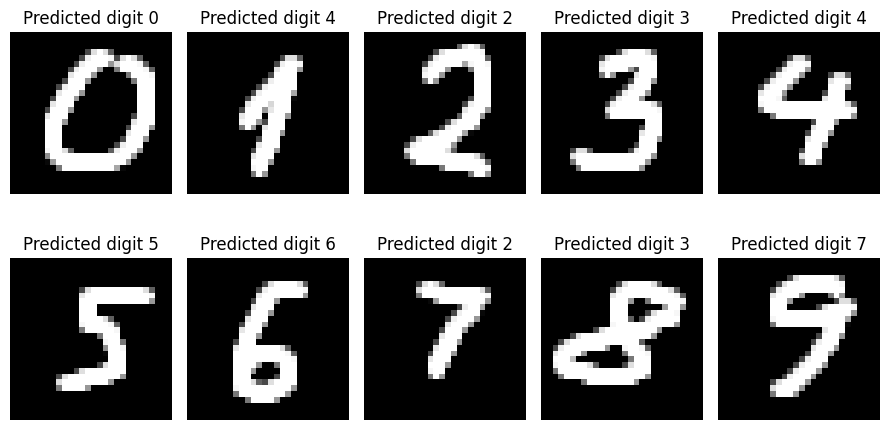

In [10]:
myTestBatch_ds = read_imgs('MyTestBatch', folder_path)

df = make_df(myTestBatch_ds)

X = df.drop(columns='label')
y = df['label']

fig, axes = plt.subplots(2, 5, figsize=(9, 5))  
axes = axes.flatten()

pred = model.predict(X)

for i in range(10):
    axes[i].imshow(myTestBatch_ds[0][i].reshape(28, -1), cmap='gray')
    axes[i].set_title(f"Predicted digit {pred[i]}")
    axes[i].axis('off')

plt.tight_layout()

plt.show()

## More indepth analysis (with script from gpt)

In [11]:
pred_probs = model.predict_proba(X)  # Get probability for each class

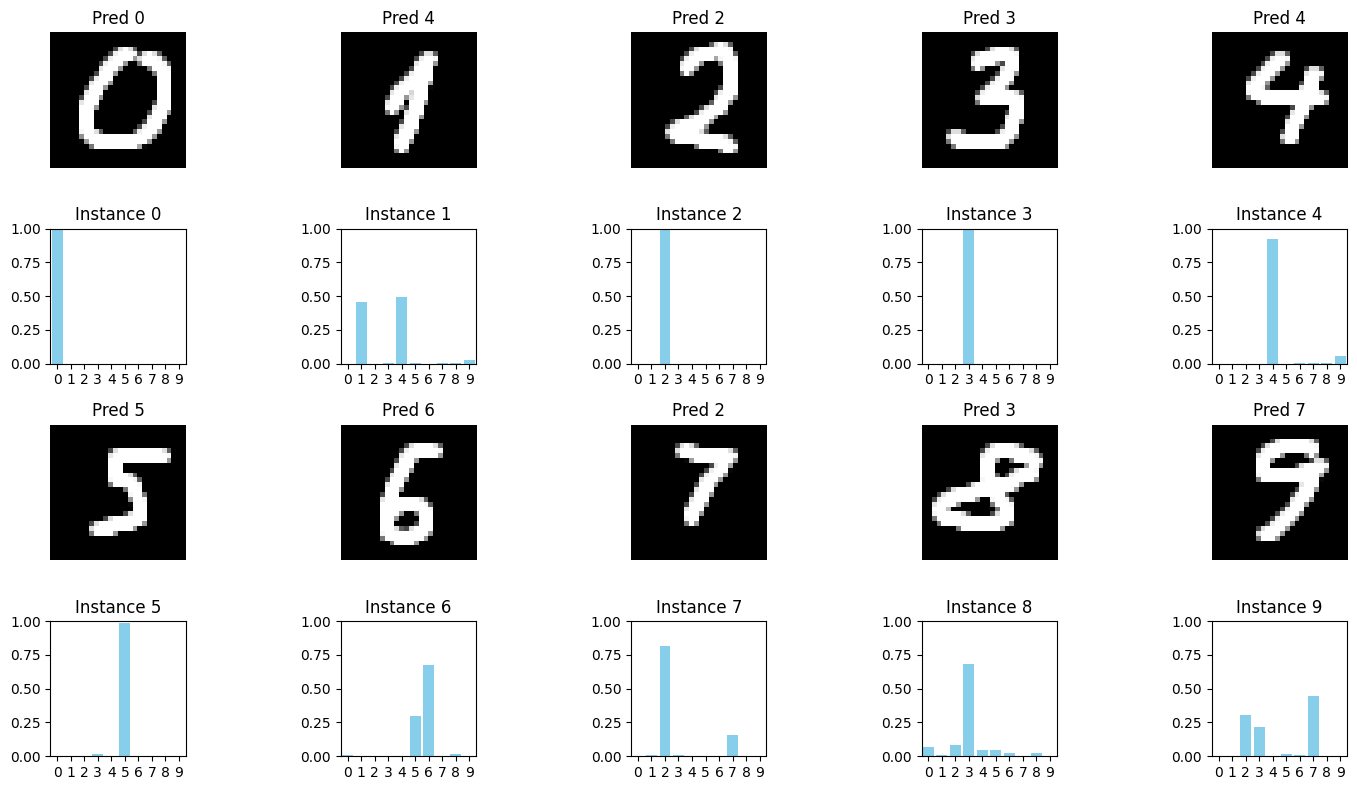

In [12]:
# 4 rows: image row, bar row, image row, bar row
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  # Wider figure
axes = axes.reshape(4, 5)

# Predict using the model
pred = model.predict(X)
pred_probs = model.predict_proba(X)

for i in range(10):
    row_offset = 0 if i < 5 else 2  # Top half or bottom half
    col = i % 5

    # Image on top
    axes[row_offset][col].imshow(myTestBatch_ds[0][i].reshape(28, 28), cmap='gray')
    axes[row_offset][col].set_title(f"Pred {pred[i]}")
    axes[row_offset][col].axis('off')

    # Histogram below
    ax_bar = axes[row_offset + 1][col]
    ax_bar.bar(range(10), pred_probs[i], color='skyblue', width=0.8)
    ax_bar.set_xticks(range(10))
    ax_bar.set_xticklabels([str(j) for j in range(10)])
    ax_bar.set_ylim(0, 1)
    ax_bar.set_xlim(-0.5, 9.5)
    ax_bar.set_title(f'Instance {i}')
    ax_bar.set_aspect((10 / 1), adjustable='box')  # 1:1 look

plt.tight_layout()
plt.show()
